# American Housing Survey Project

Explore year 2013 of national and metro datasets from the [Housing Affordability Data System (HADS)](https://www.huduser.gov/portal/datasets/hads/hads.html) data source.

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import get_test_data
from mpl_toolkits.mplot3d import Axes3D 
import seaborn as sns
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from urllib.request import urlopen
from zipfile import ZipFile
from io import BytesIO
import os.path

%matplotlib inline
%config InlineBackend.figure_format='retina'

## Read data

In [2]:
# Read Natinal Data 
national_url = 'https://www.huduser.gov/portal/datasets/hads/hads2013n_ASCII.zip'
national_file = 'thads2013n.txt'

if os.path.exists(national_file):
    national = pd.read_csv(national_file)
else: 
    z_national = urlopen(national_url)
    zip_national = ZipFile(BytesIO(z_national.read())).extract(national_file)
    national = pd.read_csv(zip_national)

In [3]:
national.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64535 entries, 0 to 64534
Data columns (total 99 columns):
CONTROL                64535 non-null object
AGE1                   64535 non-null int64
METRO3                 64535 non-null object
REGION                 64535 non-null object
LMED                   64535 non-null int64
FMR                    64535 non-null int64
L30                    64535 non-null int64
L50                    64535 non-null int64
L80                    64535 non-null int64
IPOV                   64535 non-null int64
BEDRMS                 64535 non-null int64
BUILT                  64535 non-null int64
STATUS                 64535 non-null object
TYPE                   64535 non-null int64
VALUE                  64535 non-null int64
VACANCY                64535 non-null int64
TENURE                 64535 non-null object
NUNITS                 64535 non-null int64
ROOMS                  64535 non-null int64
WEIGHT                 64535 non-null float64
PER 

In [4]:
national.head()

,CONTROL,AGE1,METRO3,REGION,LMED,FMR,L30,L50,L80,IPOV,...,FMTINCRELFMRCAT,FMTCOST06RELAMICAT,FMTCOST08RELAMICAT,FMTCOST12RELAMICAT,FMTCOSTMEDRELAMICAT,FMTINCRELAMICAT,FMTASSISTED,FMTBURDEN,FMTREGION,FMTSTATUS
0,'100003130103',82,'3','1',73738,956,15738,26213,40322,11067,...,'1 LTE 50% FMR','2 30 - 50% AMI','2 30 - 50% AMI','2 30 - 50% AMI','2 30 - 50% AMI','2 30 - 50% AMI','.','2 30% to 50%','-5','-5'
1,'100006110249',50,'5','3',55846,1100,17165,28604,45744,24218,...,'3 GT FMR','4 60 - 80% AMI','4 60 - 80% AMI','6 100 - 120% AMI','4 60 - 80% AMI','7 120% AMI +','.','1 Less than 30%','-5','-5'
2,'100006370140',53,'5','3',55846,1100,13750,22897,36614,15470,...,'2 50.1 - 100% FMR','4 60 - 80% AMI','5 80 - 100% AMI','6 100 - 120% AMI','4 60 - 80% AMI','4 60 - 80% AMI','.','3 50% or More','-5','-5'
3,'100006520140',67,'5','3',55846,949,13750,22897,36614,13964,...,'2 50.1 - 100% FMR','6 100 - 120% AMI','7 120% AMI +','7 120% AMI +','5 80 - 100% AMI','4 60 - 80% AMI','.','1 Less than 30%','-5','-5'
4,'100007130148',26,'1','3',60991,737,14801,24628,39421,15492,...,'3 GT FMR','3 50 - 60% AMI','3 50 - 60% AMI','3 50 - 60% AMI','3 50 - 60% AMI','7 120% AMI +','0 Not Assisted','1 Less than 30%','-5','-5'


## Initial Exploratory questions

### Missing Data

In [5]:
national.isnull().sum().any()

False

It looks like there are no missing values.

### 2D visualizations
Columns to explore at first:
- `ZINC2`: Household Income
- `ZSMHC`: Monthly Housing Costs
- `ROOMS`: Number of rooms in unit
- `PER`: Number of persons in household
- `GLMED`: Growth-adjusted median income
- `AGE1`: Age of head of household

In [6]:
# Make dictionary of columns and names
init_num_col_names = {'ZINC2': ' Household Income', 'ZSMHC': 'Monthly Housing Costs', 
                      'ROOMS': 'Number of rooms in unit', 
                      'PER': 'Number of persons in household', 'GLMED': 'Growth-adjusted median income', 
                      'AGE1': 'Age of head of household'}

In [7]:
# Make function for scatter plot 
def plot_2D(x_col, y_col, df, col_names_dict):
    plt.figure(figsize=(6,6))
    plt.scatter(df[x_col], df[y_col], s=10, alpha=0.3)
    plt.xlabel(col_names_dict[x_col])
    plt.ylabel(col_names_dict[y_col]);

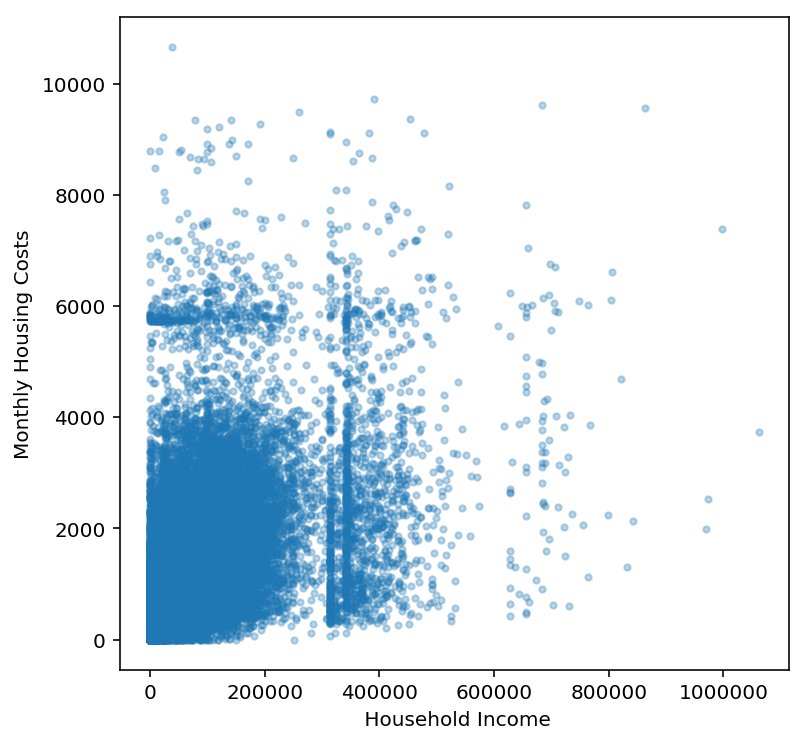

In [8]:
plot_2D(x_col='ZINC2', y_col='ZSMHC', df=national, col_names_dict=init_num_col_names)

### 3D Visualizations

In [9]:
def plot_3D(x_col, y_col, z_col, df, col_names_dict):
    plt.figure(figsize=(6,6))
    ax = plt.axes(projection='3d')
    ax.scatter3D(df[x_col], df[y_col], df[z_col], c=df[z_col], cmap='Greens')
    ax.set_xlabel(col_names_dict[x_col])
    ax.set_ylabel(col_names_dict[y_col])
    ax.set_zlabel(col_names_dict[z_col]);

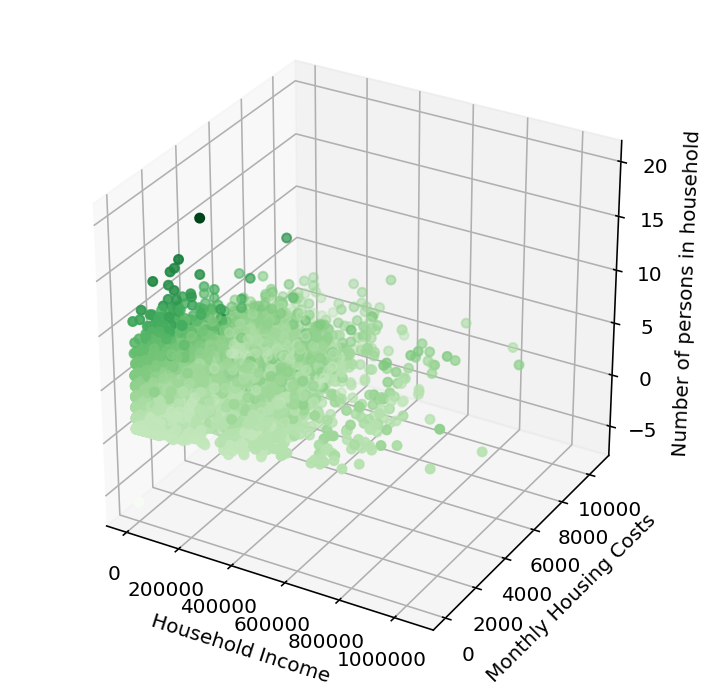

In [10]:
plot_3D(x_col='ZINC2', y_col='ZSMHC', z_col='PER',df=national, col_names_dict=init_num_col_names)

### Principal Component Analysis

Use PCA to identify the most important columns

In [11]:
cat_cols = national.columns[national.dtypes=='object']
num_cols = national.columns[national.dtypes!='object']

print(f'{len(cat_cols)} categorical columns')
print(f'{len(num_cols)} numerical columns')

32 categorical columns
67 numerical columns


In [12]:
national_processed = national.copy()

# Get OHE of categorical variables
national_processed = pd.get_dummies(national_processed)

# Scale numeric features
scaler = StandardScaler()
national_processed[num_cols] = scaler.fit_transform(national_processed[num_cols])

In [13]:
national_processed.shape

(64535, 64738)

In [14]:
# Define scree plot function
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(18, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s" % ((str(vals[i]*100)[:3])), (ind[i], vals[i]), va="bottom", ha="center", fontsize=4.5)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

In [15]:
# Apply PCA to the data
pca = PCA(40)
pca_features = pca.fit_transform(national_processed)

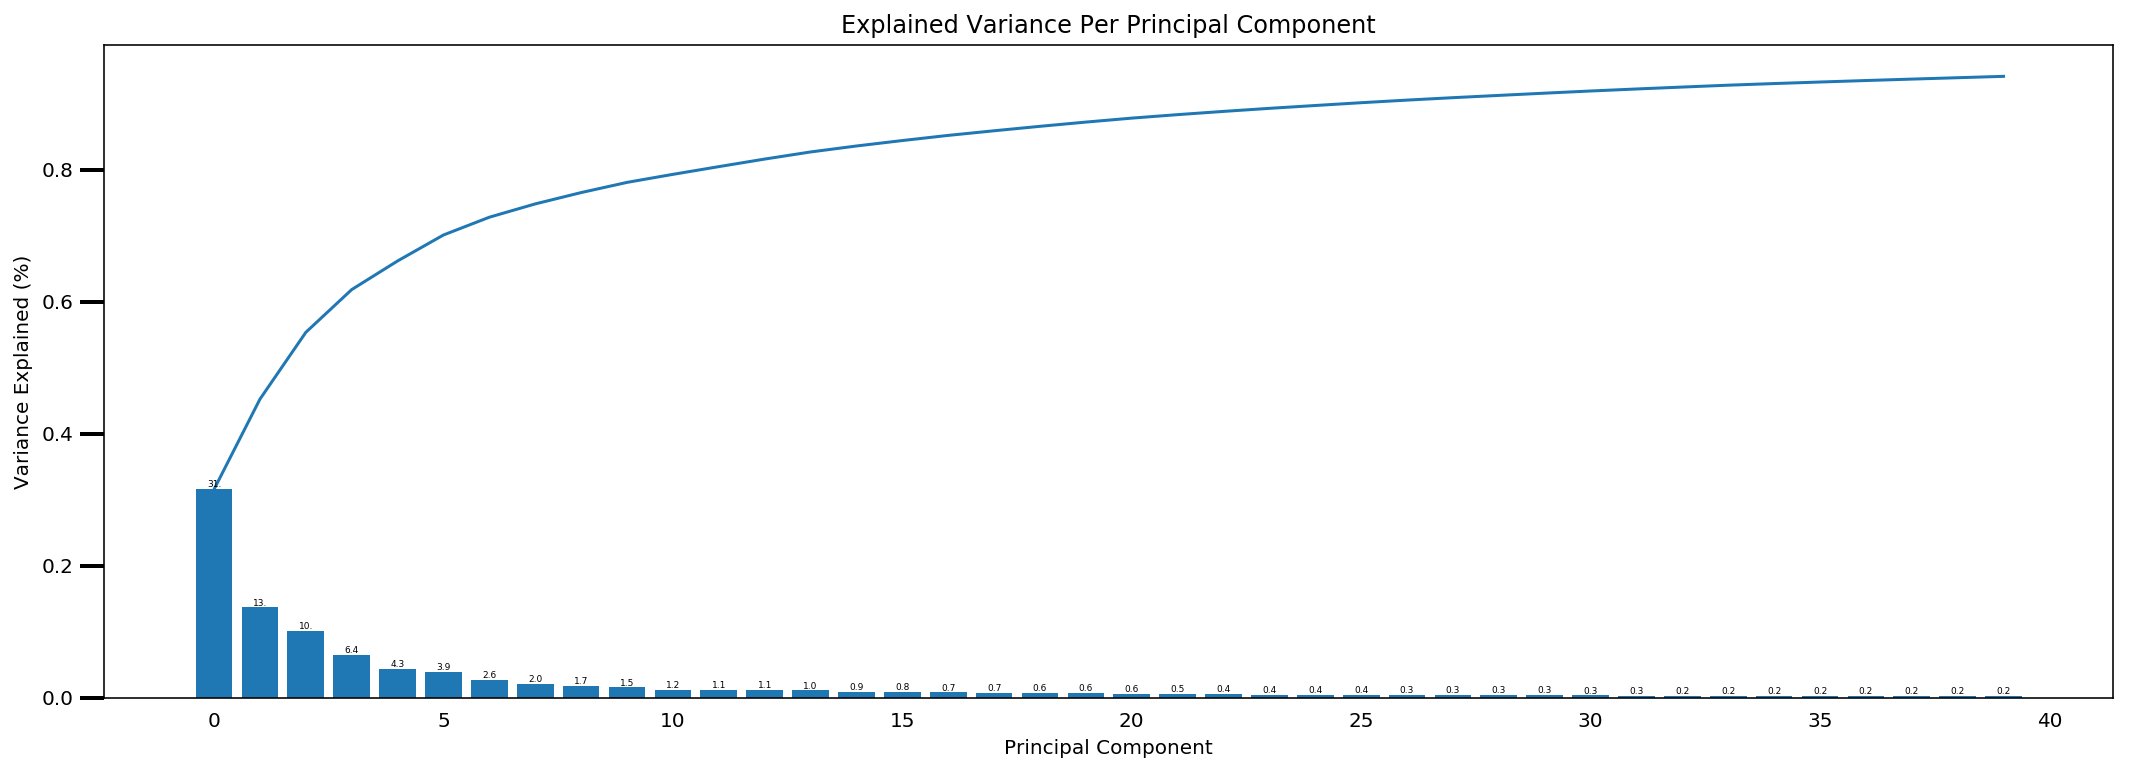

In [16]:
scree_plot(pca)

Understand the top most important components

In [42]:
def plot_pca(data, pca, n_compo):
    '''
    Plot the features with the most absolute variance for given pca component 
    '''
    compo = pd.DataFrame(np.round(pca.components_, 4), columns = data.keys()).iloc[n_compo-1]
    compo.sort_values(ascending=False, inplace=True)
    compo = pd.concat([compo.head(5), compo.tail(5)])
    
    compo.plot(kind='bar', color='#1f77b4', title='Component ' + str(n_compo))
    ax = plt.gca()
    ax.grid(linewidth='0.5', alpha=0.5)
    ax.set_axisbelow(True)
    plt.show()

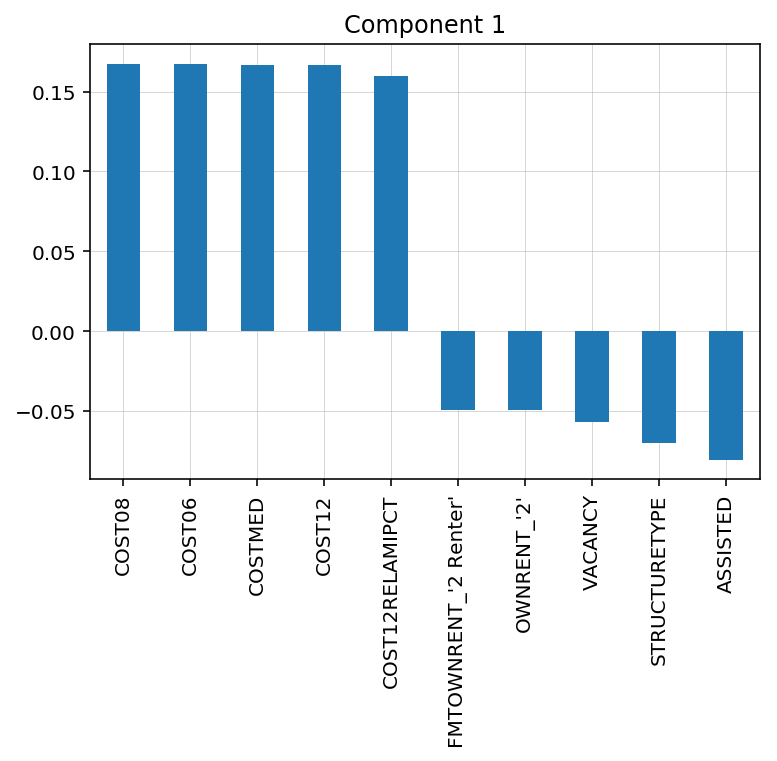

In [44]:
plot_pca(national_processed, pca, 1)

Positively related:
- `COST08`: Housing cost at 8 percent interest
- `COST06`: Housing cost at 6 percent interest
- `COSTMED`: Housing cost at Median interest
- `COST12`: Housing cost at 12 percent interest

Negatively related:
- `ASSISTED`: Assisted Housing
- `STRUCTURETYPE`: Recoded structure type
- `VACANCY`: Vacancy status
- `OWNRENT`: Tenure (adjusted)

In [ ]:
df[df.column == 2 ]

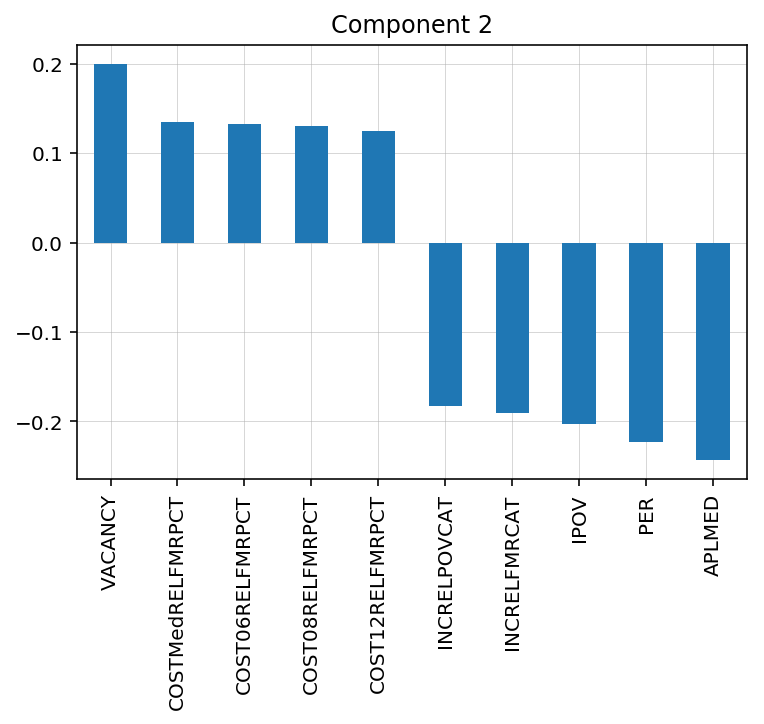

In [45]:
plot_pca(national_processed, pca, 2)

Positively related:
- `VACANCY`: Vacancy status
- `COSTMedRELFMRPCT`: CostMed Relative to FMR (Percent)
- `COST06RELFMRPCT`: Cost06 Relative to FMR (Percent)
- `COST08RELFMRPCT`: Cost08 Relative to FMR (Percent)

Negatively related:
- `APLMED`: Median Income Adjusted for # of Persons
- `PER`: # of persons in household
- `IPOV`: Poverty Income
- `INCRELFMRCAT` HH Income Relative to FMR (Category)

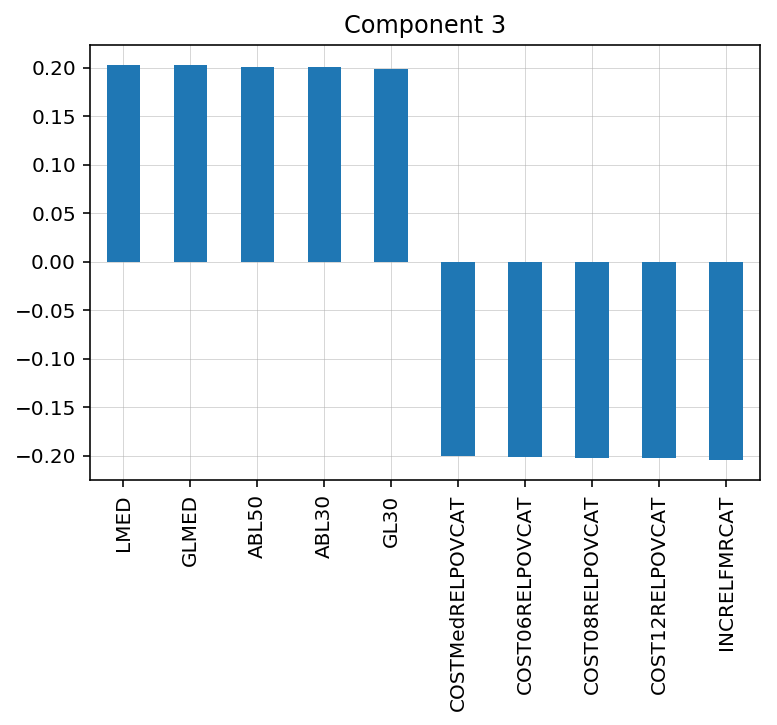

In [46]:
plot_pca(national_processed, pca, 3)

Positively related:
- `LMED`: Area median income (average)
- `GLMED`: Growth-adjusted median income
- `ABL50`: Very Low Income Adjusted for # of Bedrooms
- `GL30`: Growth-adjusted extremely low income National 2003 & later

Negatively related:
- `INCRELFMRCAT`:  HH Income Relative to FMR (Category)
- `COST12RELPOVCAT`: Cost12 Relative to Poverty Income (Category)
- `COST08RELPOVCAT`: Cost08 Relative to Poverty Income (Category)

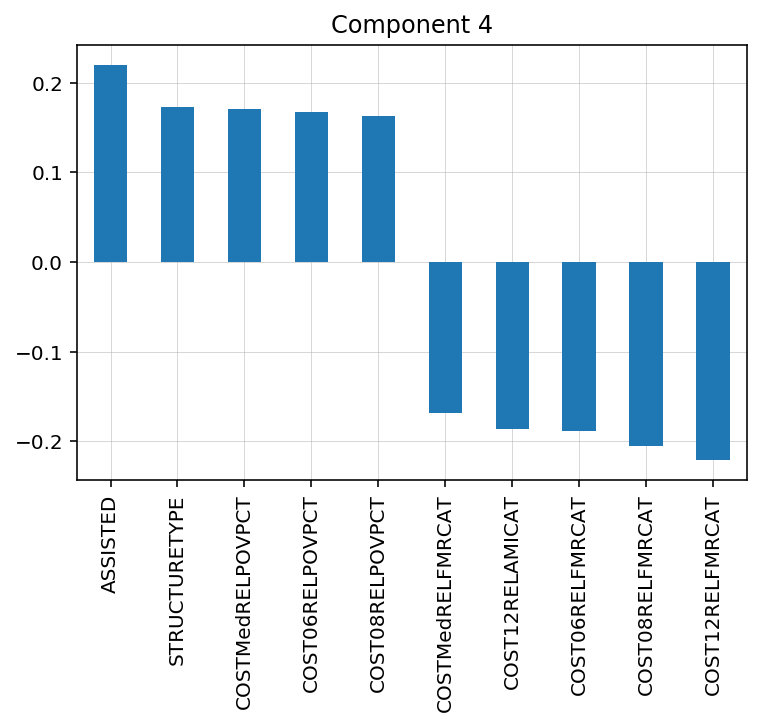

In [47]:
plot_pca(national_processed, pca, 4)

Go with top 8 most important components

In [48]:
pca = PCA(8)
pca_features = pca.fit_transform(national_processed)

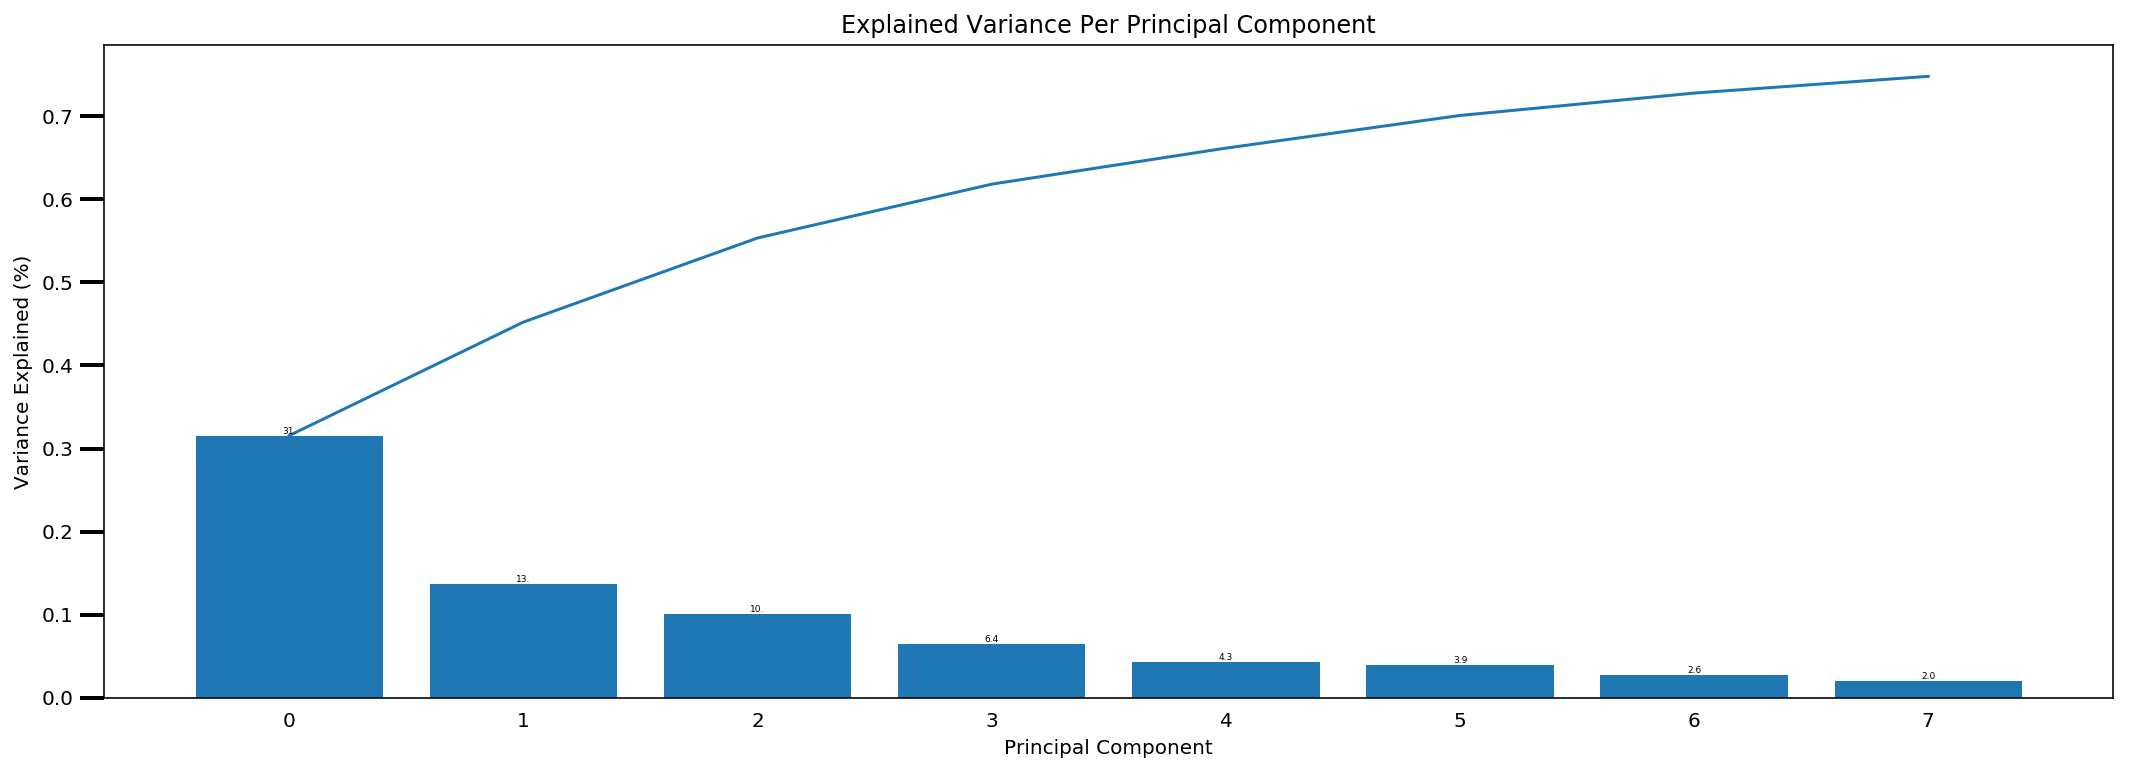

In [49]:
scree_plot(pca)

## K-Means Clustering

### K-Means traind and predict
Find the optimal number of clusters.

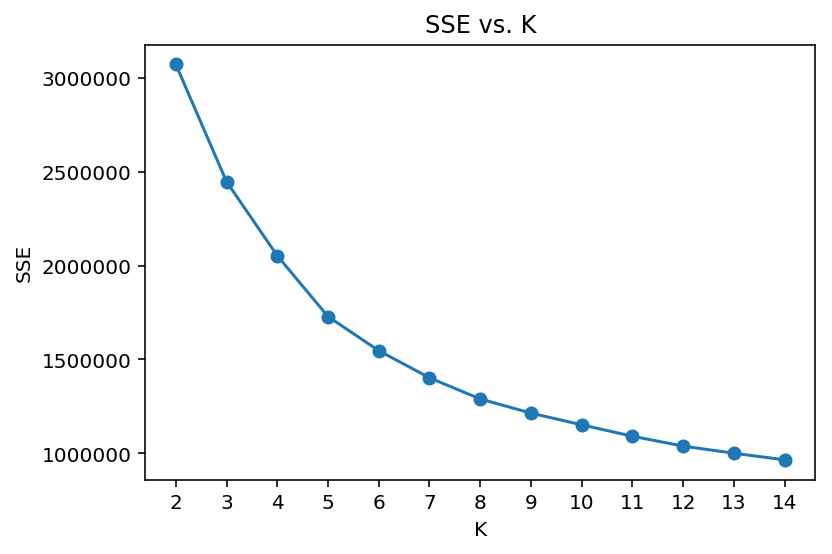

In [51]:
sse = []

k_range = np.arange(2, 15)

for k in k_range:
    kmeans = KMeans(k).fit(pca_features)
    sse.append(np.abs(kmeans.score(pca_features)))
    
plt.plot(k_range, sse, linestyle='-', marker='o', )
plt.xlabel('K')
plt.ylabel('SSE')
plt.xticks(k_range)
plt.title('SSE vs. K');

Predict cluster segments

In [52]:
kmeans = KMeans(5).fit(pca_features)

kmeans_labels = kmeans.predict(pca_features)

### K-Means evaluate

Columns to look at:

Categorical:
- `ASSISTED`: Assisted Housing
- `STRUCTURETYPE`: Recoded structure type
- `VACANCY`: Vacancy status
- `OWNRENT`: Tenure (adjusted)

Numerical:
- `COSTMED`: Housing cost at Median interest
- `COSTMedRELFMRPCT`: CostMed Relative to FMR (Percent)
- `APLMED`: Median Income Adjusted for # of Persons
- `IPOV`: Poverty Income
- `LMED`: Area median income (average)
- `GLMED`: Growth-adjusted median income
- `PER`: # of persons in household

In [118]:
def plot_segment(k):
    segment = national[kmeans_labels == k]
    print('Segment:', k)
    print('Pct of Records in Segment:', np.round(segment.shape[0]*100/national.shape[0],2))
    fig, axs = plt.subplots(1,4, figsize=(24,4))
    sns.countplot(segment['ASSISTED'], ax = axs[0], color='#1f77b4')
    sns.countplot(segment['STRUCTURETYPE'], ax = axs[1], color='#1f77b4')
    sns.countplot(segment['VACANCY'], ax = axs[2], color='#1f77b4')
    sns.countplot(segment['OWNRENT'], ax = axs[3], color='#1f77b4')

Segment: 1
Pct of Records in Segment: 19.3


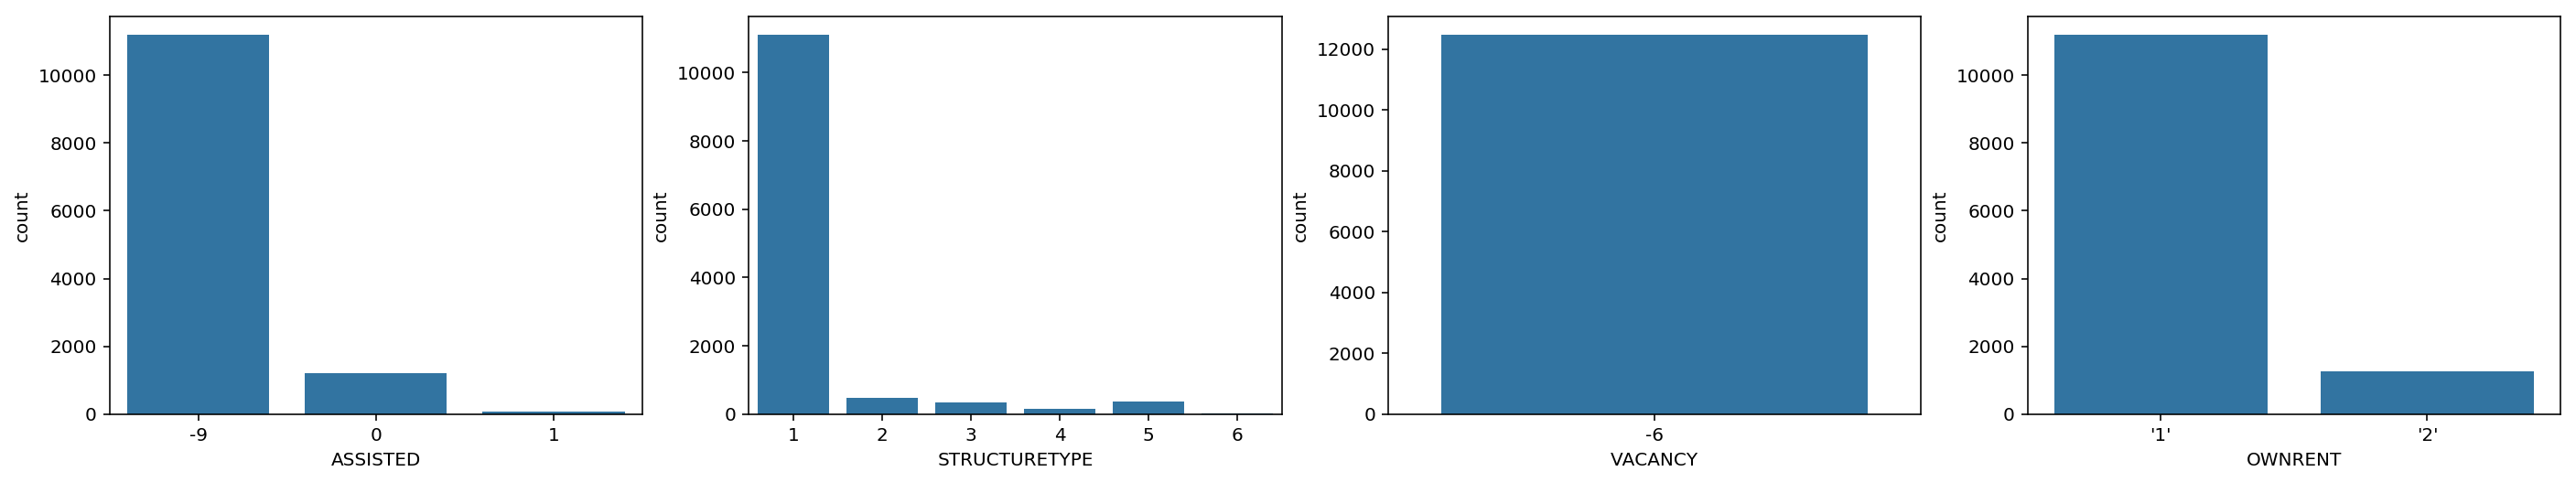

In [119]:
plot_segment(1)

Segment: 2
Pct of Records in Segment: 0.57


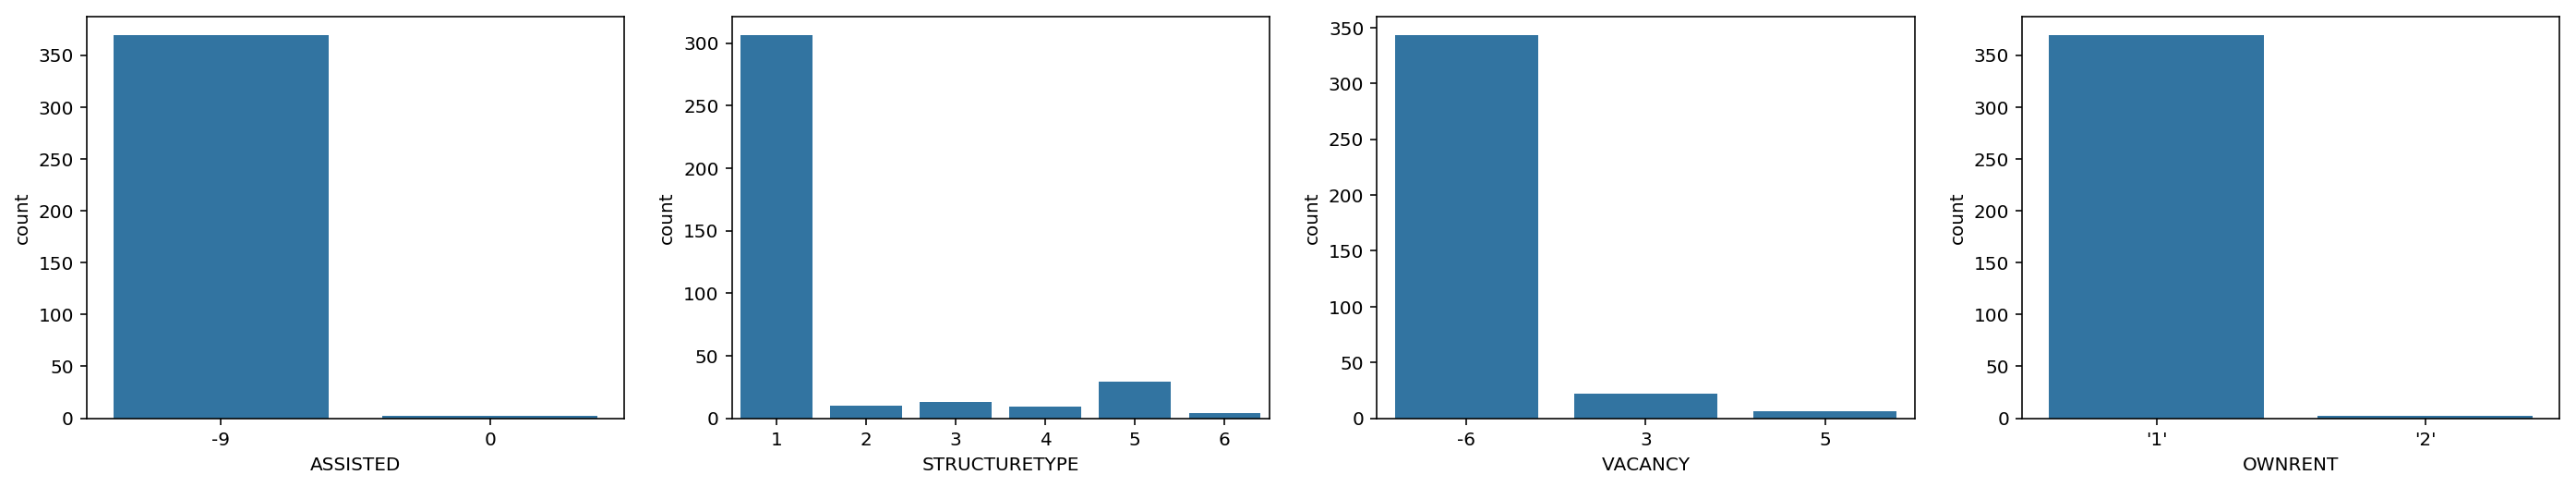

In [120]:
plot_segment(2)

Segment: 3
Pct of Records in Segment: 34.95


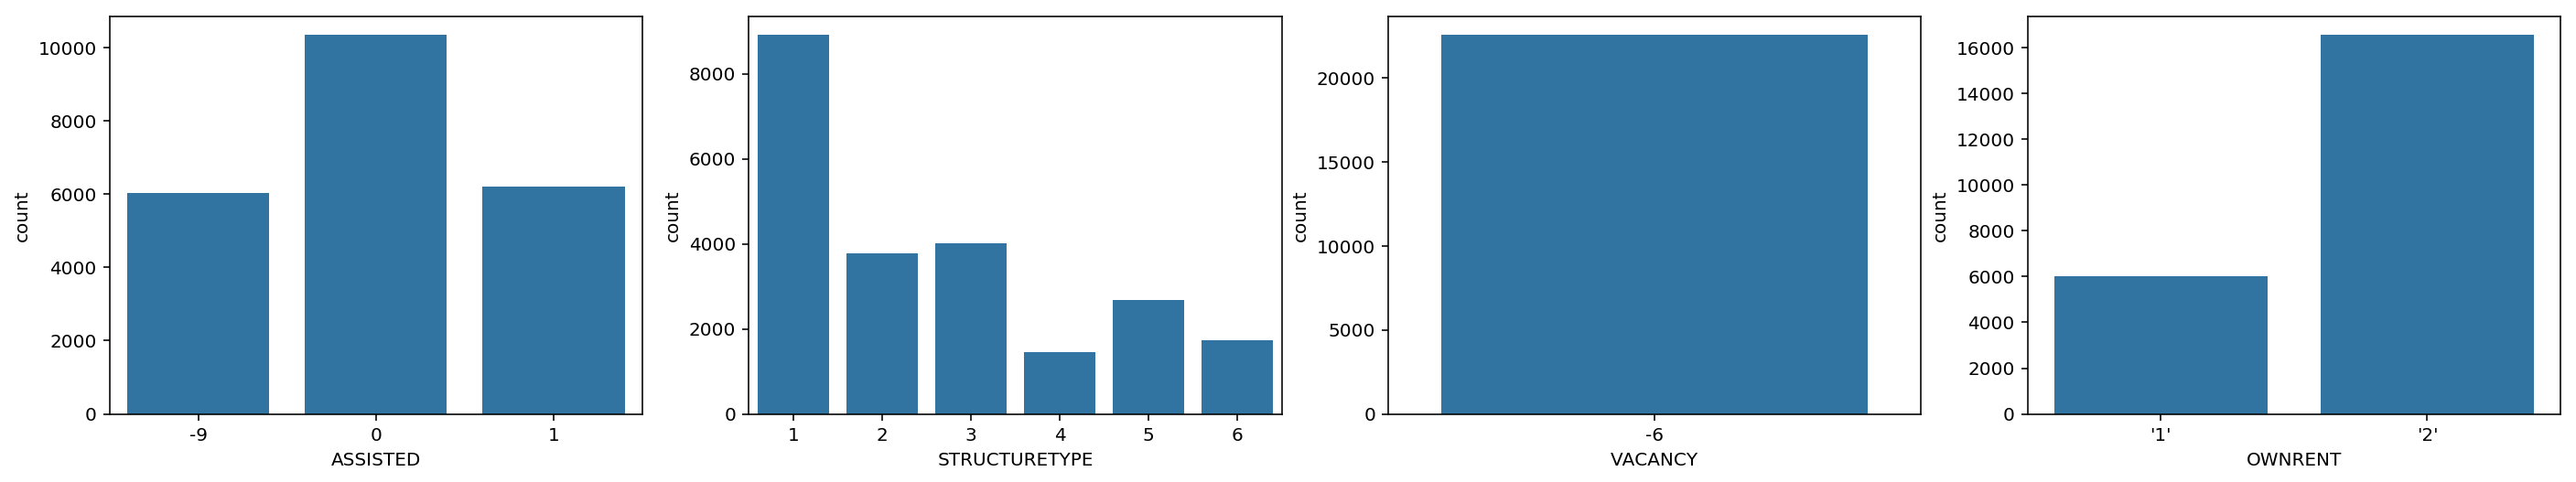

In [121]:
plot_segment(3)

Segment: 4
Pct of Records in Segment: 6.83


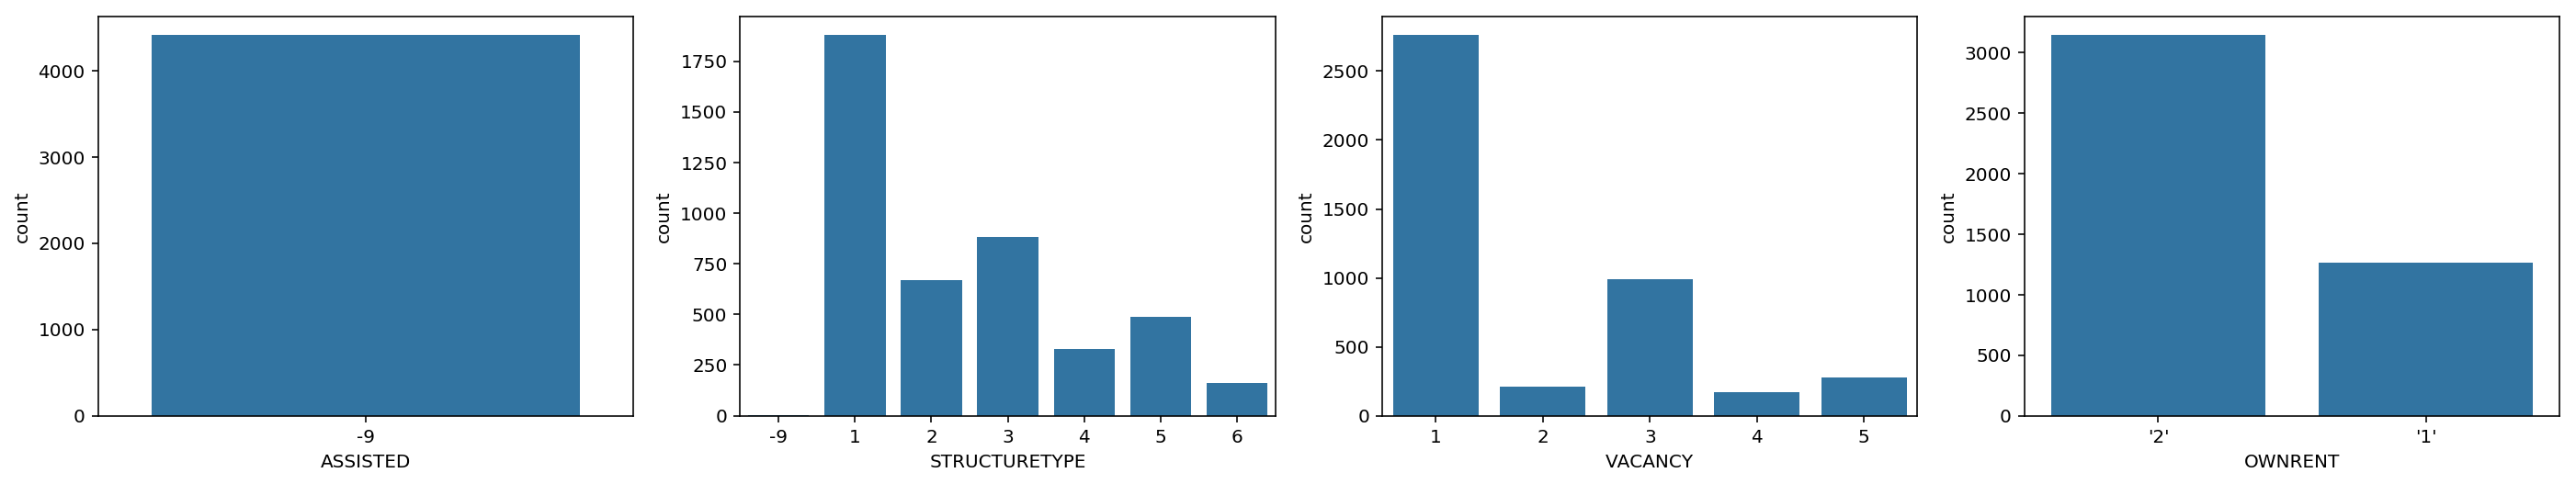

In [122]:
plot_segment(4)

Segment: 0
Pct of Records in Segment: 38.34


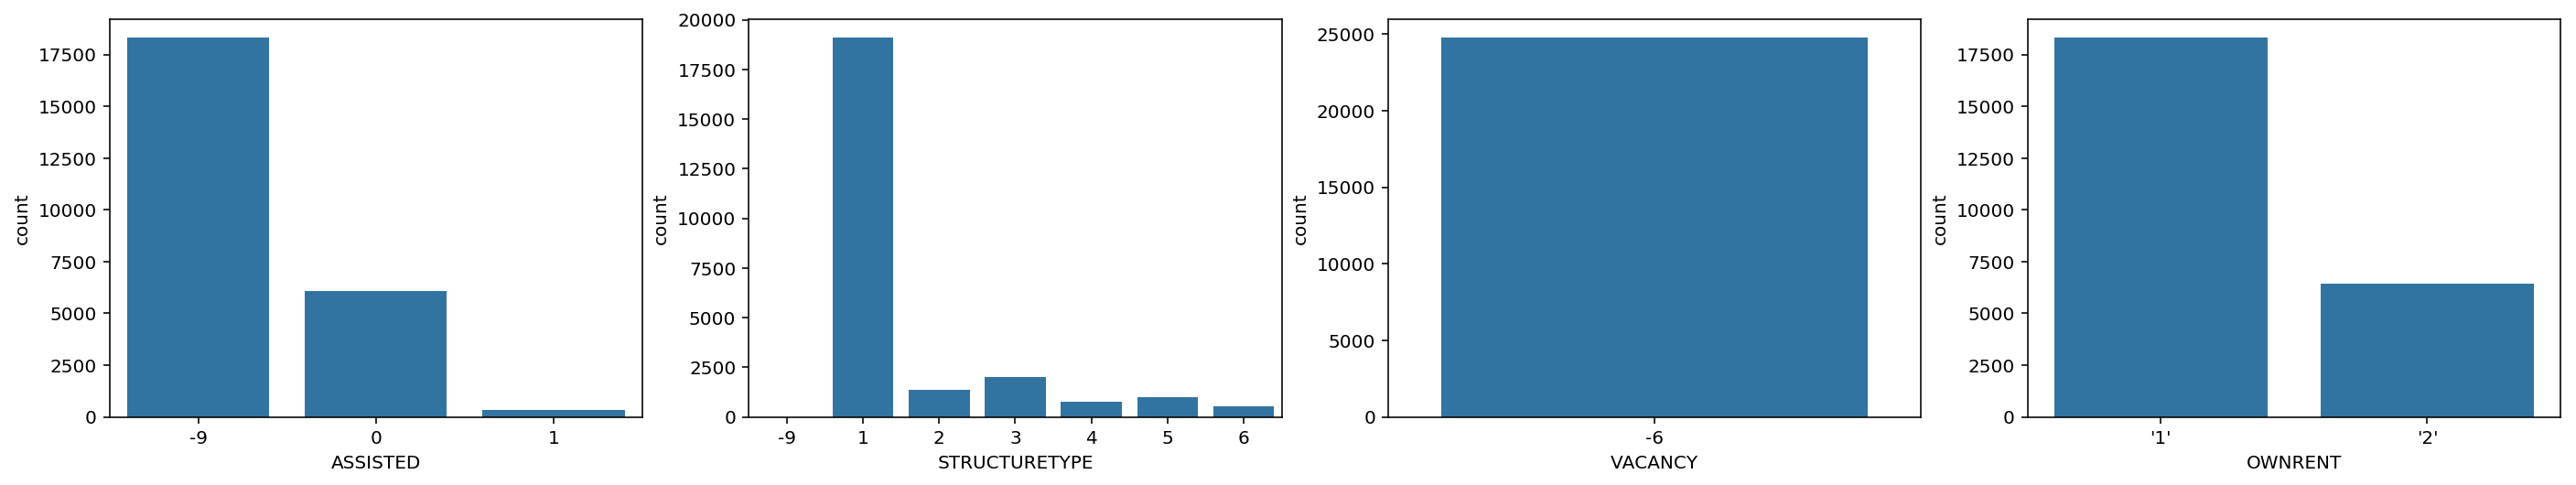

In [124]:
plot_segment(0)

In [133]:
national.groupby(kmeans_labels)['COSTMED', 'GLMED'].mean().round(2).sort_values(by='COSTMED', ascending=False)

,COSTMED,GLMED
2,14450.57,75349.44
1,2891.55,78155.62
0,1269.74,64062.18
4,1127.25,66587.92
3,577.73,67181.41


- `GLMED`: Growth-adjusted median income
- `COSTMED`: Housing cost at Median interest